In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report

from notebooks.bootstrap_notebooks import bootstrap_notebook, load_dataset, train, test, get_train_dataloader, \
    get_test_dataloader
import pytorch_lightning as pl
import torch
import torch.functional as F
from pl_bolts.models.autoencoders import VAE

from src.base.datasets.sampling_rules.balance import balanced_weight
from src.base.training.models.aes_utils import get_enc_dec
from torch.nn import Flatten, Unflatten, Sequential, Linear, ReLU
from torch.nn.functional import log_softmax, nll_loss, mse_loss
from torchmetrics import Accuracy, Precision, Recall, F1Score, MetricCollection

import torchmetrics

C:\Users\micdu\Code\pythonProject\dmtl\venv\lib\site-packages\pl_bolts\callbacks\data_monitor.py:20: UnderReviewWarning: The feature warn_missing_pkg is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  warn_missing_pkg("wandb")
C:\Users\micdu\Code\pythonProject\dmtl\venv\lib\site-packages\pl_bolts\models\self_supervised\amdim\amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
C:\Users\micdu\Code\pyth

In [2]:
EXP_NAME = "fraud_classifier"

config = {
    "exp_name": EXP_NAME,
    "enable_gpu": True,
    "training_n_dev": 1,
    "logs": "C:\\Users\\micdu\\Code\\pythonProject\\dmtl\\notebooks\\logs",
    "training_out": "C:\\Users\\micdu\\Code\\pythonProject\\dmtl\\notebooks\\lightning_data",
    "tracking_uri": "http://localhost:5000"
}
bootstrap_notebook(config)

In [3]:
load_dataset({
    "dataset": "credit_card_fraud",
    "data_path": "C:\\Users\\micdu\\Code\\pythonProject\\dmtl\\data",
})

In [15]:
class FraudDetection(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = Linear(30, 15)
        self.activation = ReLU()
        self.decoder = Linear(15, 30)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(self.activation(x))
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)
        return [optimizer], [lr_scheduler]

    def calc_loss(self, x, x_hat, log_label=''):
        loss = mse_loss(x_hat, x)
        if log_label:
            self.log(log_label, loss)
        return loss

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        x_hat = self(x)
        return self.calc_loss(x, x_hat, 'training_loss')

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self(x)
        self.calc_loss(x, x_hat, 'training_loss')

    def test_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self(x)
        self.calc_loss(x, x_hat, 'test_loss')

In [16]:
model = FraudDetection()
train(model, epochs=3)

Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type   | Params
--------------------------------------
0 | encoder    | Linear | 465   
1 | activation | ReLU   | 0     
2 | decoder    | Linear | 480   
--------------------------------------
945       Trainable params
0         Non-trainable params
945       Total params
0.004     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\micdu\Code\pythonProject\dmtl\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\micdu\Code\pythonProject\dmtl\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [17]:
test(model)

Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\micdu\Code\pythonProject\dmtl\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.110945701599121
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [18]:
model = model.eval()

In [19]:
train_dl = get_train_dataloader()

def get_reconstruction_error(loader, ae):
    recon_errors = torch.empty(size=[0, 1])
    targets = torch.empty(size=[0, 1])
    for batch, (x, y) in enumerate(loader):
        dec_x = ae(x)
        errors = torch.flatten(mse_loss(dec_x, x, reduction='none'), start_dim=1)
        errors = torch.mean(errors, dim=1).reshape(-1, 1)
        recon_errors = torch.cat((recon_errors, errors))
        targets = torch.cat((targets, y.reshape(-1, 1)))
    return recon_errors.detach().numpy(),targets.detach().numpy()

train_recon_error, targets = get_reconstruction_error(train_dl, model)

In [20]:
df = pd.DataFrame(data=np.concatenate((train_recon_error, targets), axis=1), columns=["error", "target"])

<AxesSubplot: xlabel='target', ylabel='error'>

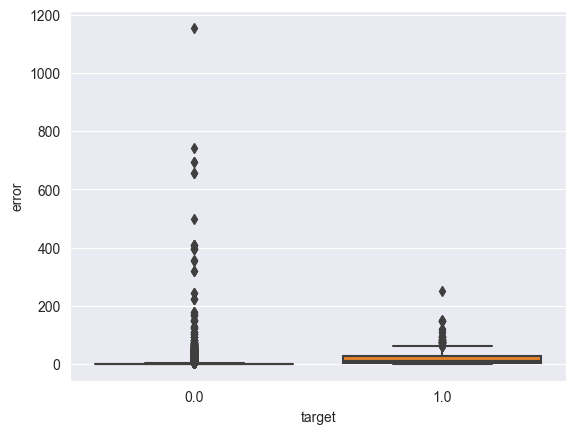

In [21]:
import seaborn as sns

sns.boxplot(df, y="error", x="target")

In [22]:
reg = LogisticRegression(class_weight='balanced').fit(df[["error"]], df.target)

In [23]:
pred = reg.predict(train_recon_error)

C:\Users\micdu\Code\pythonProject\dmtl\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [24]:
classification_report(pred, targets, output_dict=True)

{'0.0': {'precision': 0.9718896273500737,
  'recall': 0.9996701636413934,
  'f1-score': 0.985584172748658,
  'support': 187972},
 '1.0': {'precision': 0.808641975308642,
  'recall': 0.04598911707916447,
  'f1-score': 0.08702873276864308,
  'support': 5697},
 'accuracy': 0.971616520971348,
 'macro avg': {'precision': 0.8902658013293578,
  'recall': 0.5228296403602789,
  'f1-score': 0.5363064527586505,
  'support': 193669},
 'weighted avg': {'precision': 0.9670875068574805,
  'recall': 0.971616520971348,
  'f1-score': 0.9591521142283674,
  'support': 193669}}

In [14]:
test_dl = get_test_dataloader()
test_error, test_targets = get_reconstruction_error(test_dl, model)
df_test = pd.DataFrame(data=np.concatenate((train_recon_error, targets), axis=1), columns=["error", "target"])
test_pred = reg.predict(test_error)
classification_report(test_pred, test_targets, output_dict=True)

C:\Users\micdu\Code\pythonProject\dmtl\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\micdu\Code\pythonProject\dmtl\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\micdu\Code\pythonProject\dmtl\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\micdu\Code\pythonProject\dmtl\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score

{'0.0': {'precision': 1.0,
  'recall': 0.9980162213405428,
  'f1-score': 0.9990071258489952,
  'support': 56962},
 '1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 'accuracy': 0.9980162213405428,
 'macro avg': {'precision': 0.5,
  'recall': 0.4990081106702714,
  'f1-score': 0.4995035629244976,
  'support': 56962},
 'weighted avg': {'precision': 1.0,
  'recall': 0.9980162213405428,
  'f1-score': 0.9990071258489952,
  'support': 56962}}